In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import drive


In [2]:
# --- 0. Setup ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")

# --- 1a. Mount Google Drive (for Colab) ---
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# --- 1b. Constants ---
# --- !!! IMPORTANT !!! ---
# Update this path to where your file is located in Google Drive.
FILE_PATH = '/content/drive/MyDrive/shodhAI/accepted_2007_to_2018Q4.csv.gz'
# --- !!! IMPORTANT !!! ---

SAMPLE_ROWS = 200000

# Define the loan statuses that represent a "finished" loan
DEFAULT_STATUSES = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']
PAID_STATUSES = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
TERMINAL_STATUSES = DEFAULT_STATUSES + PAID_STATUSES

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.


In [3]:
# --- 2. Load and Filter Data ---
print(f"Loading {SAMPLE_ROWS} rows from {FILE_PATH}...")
try:
    df = pd.read_csv(
        FILE_PATH,
        nrows=SAMPLE_ROWS,
        compression='gzip',
        low_memory=False
    )
    print(f"Successfully loaded {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}")
    print("Please double-check the FILE_PATH variable and ensure it's correct.")
    exit()
except Exception as e:
    print(f"An error occurred: {e}")
    exit()

print("\nFiltering for terminal loan statuses (Paid or Defaulted)...")
df_filtered = df[df['loan_status'].isin(TERMINAL_STATUSES)].copy()
print(f"Filtered size (terminal loans only): {df_filtered.shape[0]} rows")

if df_filtered.empty:
    print("\nWarning: No terminal-status loans found. Try increasing SAMPLE_ROWS.")
    exit()


Loading 200000 rows from /content/drive/MyDrive/shodhAI/accepted_2007_to_2018Q4.csv.gz...
Successfully loaded 200000 rows and 151 columns.

Filtering for terminal loan statuses (Paid or Defaulted)...
Filtered size (terminal loans only): 176083 rows


In [4]:
# --- 3. Task 1a: Analyze Data (High-Level Overview) ---
print("\n--- Task 1a: Initial Data Analysis ---")
print("\nData Info (first 50 columns):")
print(df_filtered.info(verbose=True, max_cols=50))

print("\nSample Data (first 5 rows):")
print(df_filtered.head())


--- Task 1a: Initial Data Analysis ---

Data Info (first 50 columns):
<class 'pandas.core.frame.DataFrame'>
Index: 176083 entries, 0 to 199999
Data columns (total 151 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    id                                          int64  
 1    member_id                                   float64
 2    loan_amnt                                   float64
 3    funded_amnt                                 float64
 4    funded_amnt_inv                             float64
 5    term                                        object 
 6    int_rate                                    float64
 7    installment                                 float64
 8    grade                                       object 
 9    sub_grade                                   object 
 10   emp_title                                   object 
 11   emp_length                                  object 
 12   home

In [5]:
# --- 4. Task 1b: Feature Selection (Identifying "Leaky" Features) ---
print("\n--- Task 1b: Feature Selection (Identifying 'Leaky' Features) ---")
# These features contain information about the *outcome* of the loan.
# They are "leaky" because they would not be available at the time of the approval decision.
leaky_features = [
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
    'out_prncp', 'out_prncp_inv', 'pymnt_plan', 'funded_amnt', 'funded_amnt_inv'
]
print(f"Identified {len(leaky_features)} potentially leaky features to be dropped.")
print("Example leaky features:", leaky_features[:5])
print("Justification: These features (e.g., 'total_payment', 'recoveries') describe events that happen *after* a loan is approved and are thus unavailable at decision time.")



--- Task 1b: Feature Selection (Identifying 'Leaky' Features) ---
Identified 15 potentially leaky features to be dropped.
Example leaky features: ['total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee']
Justification: These features (e.g., 'total_payment', 'recoveries') describe events that happen *after* a loan is approved and are thus unavailable at decision time.



--- Task 1a: Analyzing Key Variable Distributions ---
Generating plot: Distribution of Loan Statuses...


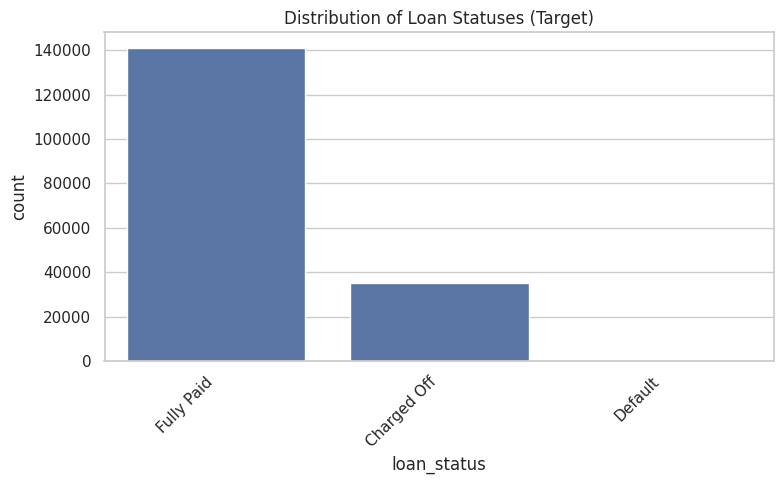

Generating plot: Distribution of log(Annual Income)...


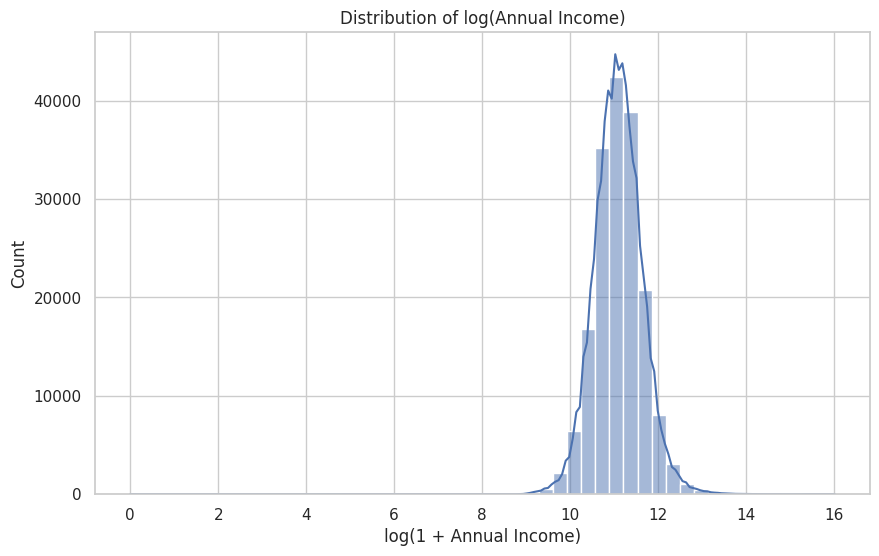

Generating plot: Distribution of Interest Rate...


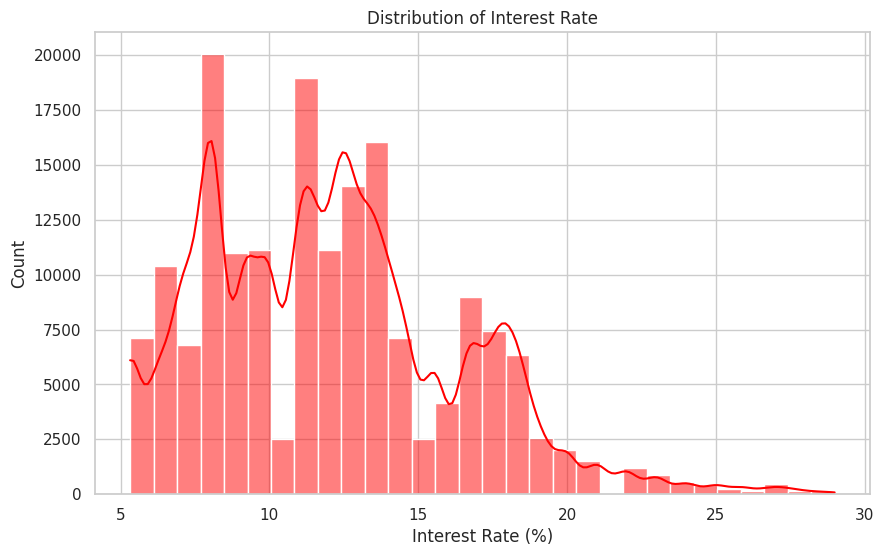

Generating plot: Distribution of Home Ownership...


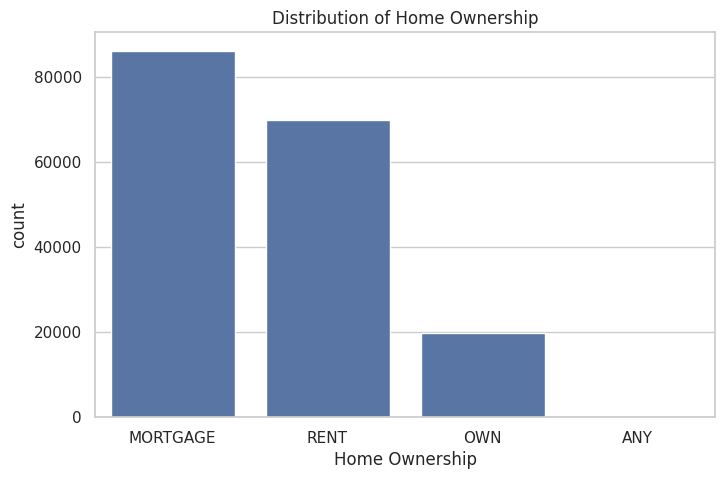

In [7]:
# --- 5. Task 1a: Analyze Data (Key Variable Distributions) ---
print("\n--- Task 1a: Analyzing Key Variable Distributions ---")

# 5.1. Loan Status (Our Target)
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_status', data=df_filtered)
plt.title('Distribution of Loan Statuses (Target)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
print("Generating plot: Distribution of Loan Statuses...")
plt.savefig('eda_1_loan_status_distribution.png')
plt.show()

# 5.2. Applicant Income (A Key Feature)
df_filtered['annual_inc'] = pd.to_numeric(df_filtered['annual_inc'], errors='coerce')
df_filtered.dropna(subset=['annual_inc'], inplace=True)
# Plotting log(annual_inc) due to strong skew
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_filtered['annual_inc']), kde=True, bins=50)
plt.title('Distribution of log(Annual Income)')
plt.xlabel('log(1 + Annual Income)')
print("Generating plot: Distribution of log(Annual Income)...")
plt.savefig('eda_2_annual_inc_distribution.png')
plt.show()

# 5.3. Interest Rate (A Key Feature)
# Convert to string first to handle potential non-string types before cleaning
df_filtered['int_rate_cleaned'] = pd.to_numeric(df_filtered['int_rate'].astype(str).str.strip().str.replace('%', ''), errors='coerce')
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['int_rate_cleaned'], kde=True, bins=30, color='red')
plt.title('Distribution of Interest Rate')
plt.xlabel('Interest Rate (%)')
print("Generating plot: Distribution of Interest Rate...")
plt.savefig('eda_3_int_rate_distribution.png')
plt.show()

# 5.4. Home Ownership (A Key Categorical Feature)
plt.figure(figsize=(8, 5))
sns.countplot(x='home_ownership', data=df_filtered, order=df_filtered['home_ownership'].value_counts().index)
plt.title('Distribution of Home Ownership')
plt.xlabel('Home Ownership')
print("Generating plot: Distribution of Home Ownership...")
plt.savefig('eda_4_home_ownership_distribution.png')
plt.show()

In [8]:
# --- 6. Task 1b/1c: Analyze Missing Values & Justify Selection ---
print("\n--- Task 1c: Missing Value Analysis & Feature Justification ---")

# Our proposed feature set
NUMERIC_FEATURES = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc'
]
CATEGORICAL_FEATURES = [
    'grade', 'emp_length', 'home_ownership', 'verification_status'
]
ALL_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES

# Clean these features *before* checking for nulls
df_analysis = df_filtered.copy()
# Convert to string first to handle potential non-string types before cleaning
df_analysis['int_rate'] = pd.to_numeric(df_analysis['int_rate'].astype(str).str.strip().str.replace('%', ''), errors='coerce')
df_analysis['revol_util'] = pd.to_numeric(df_analysis['revol_util'].astype(str).str.strip().str.replace('%', ''), errors='coerce')

print(f"Analyzing missing values for our {len(ALL_FEATURES)} selected features:")
missing_counts = df_analysis[ALL_FEATURES].isnull().sum()
missing_percent = (missing_counts / len(df_analysis)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percent': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Percent', ascending=False))


--- Task 1c: Missing Value Analysis & Feature Justification ---
Analyzing missing values for our 13 selected features:
            Missing Count  Missing Percent
emp_length          11134         6.323154
revol_util             69         0.039186
dti                     2         0.001136
